In [1]:
import numpy as np
import math
from math import cos, sin
import matplotlib.pyplot as plt
import matplotlib.tri as tri

from scipy.spatial import Delaunay
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import inv, cg, spsolve

pi = math.pi

# Solving the Forward Problem of EIT with FEM

In this notebook we will introduce the framework to simulate voltage measurements for a given conductivity. The objective of the forward problem is given a conductivity inside the body and a current applied on the boundary to determine the electrical potential inside the body and the one that will be measured by a simulated device. This is modeled by the complete Electrode Model:

$$\begin{cases}
\nabla\cdot(\sigma\nabla u)=0 \quad \text{ in } \Omega \\
\left.u + z_l\sigma\frac{\partial u}{\partial\nu}\right|_{e_k} = U_k,\quad k=1,...,L\\
\int_{e_k} \sigma\frac{\partial u}{\partial\nu}\,ds = I_k,\quad k=1,...,L\\
\sigma\left.\frac{\partial u}{\partial\nu}\right|_{\partial\Omega\setminus \cup e_k} = 0 \\
\end{cases}$$

Uniqueness of a solution holds in the space $H^1(\Omega)\times \mathbb{R}^L$ such that $\sum_{k=1}^L U_k=0$.

The $\textbf{weak formulation}$ of this PDE system is given by: 

$$ \int_{\Omega} \sigma\nabla u\cdot\nabla v dx + \sum_{k=1}^L \frac{1}{z_k} \int_{e_k} \left(u-U_k\right) \left(v-V_k\right)\,ds = \sum_{k=1}^L I_kV_k.$$


### Discretization:

The first step to apply the FEM is to obtain a proper discretization of the domain. For such we will use a simple distmesh2D algorithm and partition the domain $\Omega$ into $N$ elements. In a first practical scenario we consider $\Omega$ to be the disk of radius $1$, but we keep in mind that the distmesh2D is general for various geometries.


## Distmesh2D Algorithm


In [2]:
# Distance Function to the boundary
def fd(p):
    # Input vector of points
    # Output the distance of this points to the boundary (<0 inside domain, =0 on boundary, >0 outside domain)
    
    return np.sqrt(np.sum(np.power(p,2),1))-1

# Represents the initial  
def fh(p):
    
    return np.ones((len(p),1))

h0 = 0.05

In [3]:
# Calibration Constants 
dptol =  0.001; ttol = 0.1; Fscale = 1.2; deltat = 0.2; geps = 0.001*h0; deps = np.sqrt(np.finfo(np.double).eps)*h0

In [4]:
el_L = 16                                                         # Number of Electrodes
dt = np.linspace(0,2*pi,el_L+1)

''' Define points fixed on the boundary. This points are connected with the electrodes.

For each electrode we fix three points on at the center and the other at the extremes.
The electrodes are considered to have a fixed and equal length.
'''

pfix = np.zeros((el_L*3,2))
el_len = pi/32

el_center = np.zeros((el_L), dtype=int)


for k in range(el_L):
    pfix[3*k,0]= cos(dt[k])
    pfix[3*k,1] = sin(dt[k])
    pfix[3*k+1,0] = cos(dt[k]+el_len/2)
    pfix[3*k+1,1] = sin(dt[k]+el_len/2)
    pfix[3*k+2,0] = cos(dt[k]+el_len)
    pfix[3*k+2,1] = sin(dt[k]+el_len)
    
    el_center[k]=int(3*k+1)
    


In [5]:
def remove_duplicate_nodes(p, pfix, d):
    
    for row in pfix:
        
        pdist = np.sqrt(np.sum((p-row) ** 2, axis=1))
        
        p = p[pdist>d]
    
    return p
        

In [6]:
# 1. Create initial distribution in bounded box [-1,1]^2
x,y = np.meshgrid(np.arange(-1,1,h0), np.arange(-1,1,h0 * math.sqrt(3) / 2.0))
x[1::2, :] += h0 / 2.0
pts = np.array([x.ravel(), y.ravel()]).T

# 2. Determine if the points are inside or close to the boundary
pts = pts[fd(pts) < geps]
r0 = 1/fh(pts)**2
selection = np.random.rand(pts.shape[0],1) < (r0 / np.max(r0))
pts = pts[selection[:,0],:]


pts = remove_duplicate_nodes(pts, pfix, geps)

# 3. Stack fixed points on boundary and the other points
pts = np.vstack((pfix, pts))
N = len(pts)
pold = np.inf * np.ones((N, 2))

In [7]:
# 4. Iterate and stabilise forces.
while 1:
    if (np.max(np.sqrt(np.sum(np.power(pts-pold,2),1))/h0)>ttol):
        pold=pts
        t = Delaunay(pts).simplices
        pmid = ( pts[t[:,0],:] + pts[t[:,1],:]+pts[t[:,2],:] )/3
        t = t[fd(pmid)<-geps]

        # Describe bars
        bars = np.vstack( ( t[:,[0,1]],t[:,[0,2]], t[:,[1,2]] ) )
        bars = np.unique(np.sort(bars,1), axis=0)
        
   

    barvec = pts[bars[:,0],:]-pts[bars[:,1],:]
    L = np.sqrt(np.sum(np.power(barvec,2),1)).reshape(len(barvec),1)
    hbars = fh(pts[bars[:,0],:]/2+pts[bars[:,1],:]/2)
    L0 = hbars*Fscale*np.sqrt(np.sum(np.power(L,2))/np.sum(np.power(hbars,2)))
    F = np.maximum(L0-L, np.zeros((len(L),1)))
    Fvec = np.multiply((F/L)*[1,1],barvec)

    data = np.hstack([Fvec, -Fvec])
    rows = (bars[:, [0, 0, 1, 1]])
    cols = np.dot(np.ones(np.shape(F)), np.array([[0, 1, 0, 1]]))


    Ftot = csr_matrix(
                (data.reshape(-1), [rows.reshape(-1), cols.reshape(-1)]),
                shape=(N, 2),
            )
    Ftot=Ftot.toarray()
    Ftot[0:len(pfix),:]=0
    pts = pts + deltat*Ftot

    d = fd(pts); ix=d>0

    pix = pts[ix]
    deps_vx = np.hstack((deps*np.ones((len(pix),1)), np.zeros((len(pix),1))))
    deps_vy = np.hstack((np.zeros((len(pix),1)), deps*np.ones((len(pix),1))))

    dgradx = (fd(pts[ix]+deps_vx)-d[ix])/deps
    dgrady = (fd(pts[ix]+deps_vy)-d[ix])/deps

    pts[ix] = pts[ix] - np.vstack((d[ix]*dgradx, d[ix]*dgrady)).T


    if np.max(np.sqrt(np.sum(np.power(deltat*Ftot[d<-geps],2),1))/h0)<dptol:
        break

In [8]:
def mesh_plt(pts, t, pfix):
    plt.triplot(pts[:,0], pts[:,1], t)
    plt.plot(pts[:,0], pts[:,1], '.')
    plt.plot(pfix[:,0], pfix[:,1], 'x')
    plt.show()

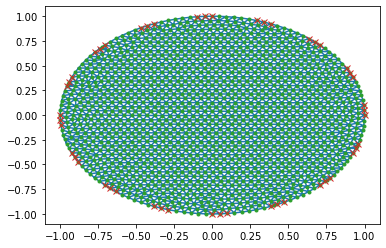

In [9]:
mesh_plt(pts,t,pfix)

In [10]:
t=np.unique(np.sort(t,1), axis=0)
t

array([[   0,    1,  827],
       [   0,  748,  788],
       [   0,  788,  827],
       ...,
       [1489, 1490, 1491],
       [1489, 1491, 1498],
       [1490, 1491, 1492]], dtype=int32)

In [11]:
def boundary_pts(fd, p):
    '''
    Determine boundary points

    Input: 
    fd - distance function to boundary; 
    p - points of the mesh

    Output: 
    bd_pts - np.array of boundary points
    ix_bd_pts - np.array of boundary point indices at general array
    '''    
    bd_pts = np.zeros((0,2))
    ix_bd_pts = np.zeros((0,1))
    dist = fd(p)
    ix_bd_pts = []
    
    for n in range(len(p)):
        
        if abs(dist[n])<=1e-5:
            bd_pts = np.vstack((bd_pts,p[n,:]))
            ix_bd_pts.append(n)
    
    ix_bd_pts = np.array(ix_bd_pts)
    
    return bd_pts, ix_bd_pts

In [12]:
bd_pts, ix_bd_pts = boundary_pts(fd, pts)


In [13]:
def ele_intersect(nn, len_, pts, id_pts):                    
    '''
    Determine for each electrode the boundary points indices it intersects
    
    Input:
    el_len - length of electrodes in terms of degree
    bd_pts - boundary points
    
    Output:
    ix_ele - list of indices of boundary points in each electrode   
    '''
    
    n = len(pts)
                                                    
    alp_bd = np.arctan2(pts[:,1], pts[:,0])   # Angles of the boundary points [-pi, pi]
    idx = alp_bd<0; alp_bd[idx] += 2*pi       # Angles of the boundary points [0, 2*pi]
    
    
    
    dt = np.linspace(0, 2*pi, nn+1)                 # Angles of the center of electrode
    alp_ele = dt[0:nn]                              
                                            
    ix_ele = [[] for i in range(nn)]                # Empty list of to insert the boundary pts for each electrode
    
    
    #  For each boundary point we see if it is the range of the Electrode [alp_ele - l/2; alp_ele + l/2]
    # Each boundary point can only intersect at most one electrode
    for jj in range(n):
        for j in range(nn):
            
            
            if np.abs(alp_ele[j]+len_/2-alp_bd[jj])<=len_/2+1e-5 or np.abs(alp_ele[j]+len_/2-alp_bd[jj]+2*pi)<=len_/2:
                ix_ele[j].append(id_pts[jj])
                break
                
    
    return ix_ele
   

In [14]:
ix_ele = ele_intersect(el_L, el_len, bd_pts, ix_bd_pts)

In [15]:
def sort_ele(pts, ix):
    
    
    
    theta = np.arctan2(pts[ix,1], pts[ix,0])
    n = len(theta)
    
    while theta[n-2]>theta[n-1]:
        
        p = theta[n-1]
        ii = ix[n-1]
        
        for j in range(n-1):
            
            if p<theta[j]:
                theta=np.insert(theta, j, p)
                theta=np.delete(theta, n)
                
                ix = np.insert(ix,j,ii)
                ix = np.delete(ix, n)
                break
    
    return ix
    

def sort_bd(pts, ix_ele):
    
    for j in range(len(ix_ele)):
        
        ix_ele[j] = list(sort_ele(pts, ix_ele[j]))
        
    return ix_ele   
    
def ele_bd_edges(nlist):
    
    edges = [[] for j in range(len(nlist))]
    
    for j in range(len(nlist)):
        
        for jj in range(len(nlist[j])-1):
            
            edges[j].append([nlist[j][jj], nlist[j][jj+1]])
                             
    return edges
        
        

In [16]:
ix_ele = sort_bd(pts,ix_ele)


edges = ele_bd_edges(ix_ele)
edges



[[[0, 1], [1, 2]],
 [[3, 4], [4, 5]],
 [[6, 7], [7, 8]],
 [[9, 10], [10, 11]],
 [[12, 13], [13, 14]],
 [[15, 16], [16, 17]],
 [[18, 1339], [1339, 19], [19, 20]],
 [[21, 22], [22, 1024], [1024, 23]],
 [[24, 25], [25, 26]],
 [[27, 28], [28, 29]],
 [[30, 31], [31, 32]],
 [[33, 34], [34, 35]],
 [[36, 37], [37, 38]],
 [[39, 76], [76, 40], [40, 41]],
 [[42, 43], [43, 229], [229, 44]],
 [[45, 46], [46, 513], [513, 47]]]

In [17]:
pts[45,:]

array([ 0.92387953, -0.38268343])

# Stiffness Matrix

Now that the discretization is established and the electrodes are properly positione and described through the mesh we assume the following approximation of our solution:

$$ u^h(x) = \sum_{i=0}^N \alpha_i\phi_i(x), $$

for $N$ the number of nodes in the mesh and $\{\phi_i\}$ piecewise linear functions that are equal to $1$ on their corresponding node $i$ and zero in the rest.

Moreover, the voltages are given through:

$$ U = \sum_{j=1}^{L-1} \beta_j\eta_j,$$

where $\eta_1 = (1, -1, 0,...,0)^T \in \mathbb{R}^L,\, \eta_2=(1,0,-1,...,0)^T, etc...$, which ensures that $\sum_{k=1}^{L} U_k=0$.

Finally, we assume that our conductivity is constant in each triangle and therefore is given by:

$$ \sigma(x) = \sum_{l=0}^T \sigma_l \chi_{T_l}(x), $$

for $\xi_{T_l}$ representing the characteristic function of the triangle $T_l$.


Under these discretizations, it follows that the stiffness matrix is given by:


$$ \left[\begin{matrix}
B & C \\
C^T & D
\end{matrix}\right]$$

$$ B \in \mathbb{R}^{N\times N}, \quad B_{ij} = \int_{\Omega} \sigma(x) \nabla\phi_i\cdot\nabla\phi_j\, dxdy + \sum_{l=1}^L \frac{1}{z_l} \int_{e_l} \phi_i\phi_j\,ds,\, i,j = 1, ..., N$$

$$C\in \mathbb{R}^{N\times L-1},\quad C_{ik} = - \frac{1}{z_1} \int_{e_1} \phi_i\,ds + \frac{1}{z_{j+1}}\int_{e_{j+1}} \phi_i\,ds, \quad i=1,...,N,\,j=1,...,L-1$$

$$ D\in\mathbb{R}^{L-1\times L-1},\quad D_{sk} = \frac{|e_1|}{z_1},\, s\neq k,\quad D_{sk}=\frac{|e_1|}{z_1}+\frac{|e_{k+1}|}{z_{k+1}}, s=k.$$

In [18]:
def det(J):
# Determinant of 2x2 matrix           

    return  J[0,0]*J[1,1]-J[0,1]*J[1,0]

def inv_2(J):
    
    inv_J = np.zeros((2,2))
    
    inv_J[0, 0] = J[1, 1]
    inv_J[1, 1] = J[0, 0]
    inv_J[1, 0] = -J[1, 0]
    inv_J[0, 1] = -J[0, 1]
    
    return inv_J

In [19]:
def assemble_B_Tk(p, Tk, sigma_k):
    
    p1 = p[Tk[0],:]
    p2 = p[Tk[1],:]
    p3 = p[Tk[2],:]
    
    J = np.zeros((2,2))
    
    J[:,0] = (p2 - p1)
    J[:,1] = (p3 - p1)
    
    det_J = det(J) # Determinant of J
    inv_J = (1/det_J)*inv_2(J.T)  # inverse of J^T
    
    # Multiplication of (J^T)^(-1) by the gradients of local element functions
    g = np.matmul(inv_J, np.array([[-1, 1, 0], [-1,0, 1]]))
    
    local_B = np.zeros((3,3))
    
    
    for j in range(3):        
        for jj in range(j, 3):
            
            local_B[j, jj] = np.dot(g[:,j], g[:, jj])
            
            if j != jj:                       
                local_B[jj, j] = local_B[j, jj]
    
    
    return ((sigma_k*abs(det_J))/2)*local_B

In [20]:
def assemble_B_edges( p, edge, zl):
    
    left = p[edge[0],:]
    right = p[edge[1],:]
    
    mod = np.sqrt(np.sum(np.power(left-right,2)))
    
    point1 = (1/6)*zl*mod
    point2 = zl*(1/3)*mod
    
    return point1, point2

In [21]:
def assemble_C_edges( p, edge, zl):
    
    left = p[edge[0],:]
    right = p[edge[1],:]
    
    return (1/2)*zl*np.sqrt(np.sum(np.power(left-right,2)))

To compute $B$ we split it into two matrices where one constructs the integral over $\Omega$ and other over the electrodes: $B=B_1+B_2$.

In [22]:
def assemble_B1(p, t, sigma):
    
    N = len(p)
    K = len(t)
    
    B1 = np.zeros((N,N))
    
    for k in range(K):
        tk = t[k]
        local_B = assemble_B_Tk(p, tk, sigma[k])
        
        ''' This can be made faster without the computation of the lower triangular!'''
        for i in range(3):
            for j in range(3):
                
                B1[tk[i], tk[j]] += local_B[i, j]
    
    return B1

In [23]:
x=0
x+=1
x

1

In [24]:
def assemble_B2(el_L, z, p, bd_edge):
    
    N=len(p)
    
    B2 = np.zeros((N,N))
    
    for l in range(el_L):
        sig_l = 1/z
        for edge in bd_edge[l]:
            s1, s2 = assemble_B_edges(p, edge, sig_l)
                    
            B2[edge[0], edge[1]] += s1
            B2[edge[1], edge[0]] += s1
            
            B2[edge[0], edge[0]] += s2
            B2[edge[1], edge[1]] += s2
            
            
    return B2
    

In [25]:
def assemble_C(el_L, z, p, bd_edge):
    
    N=len(p)
    
    C = np.zeros((N, el_L-1))
    
    # Electrode e_1
    
    sig_1 = 1/z
    
    for edge in bd_edge[0]:
        
        s = -assemble_C_edges(p, edge, sig_1)
        
        C[edge[0], :] += s
        C[edge[1], :] += s
        
    for l in range(el_L-1):
        
        sig_l = 1/z
        
        for edge in bd_edge[l+1]:
            
            s2 = assemble_C_edges(p, edge, sig_l)
            
            C[edge[0], l] += s2
            C[edge[1], l] += s2
            
    
    return C
            
            

In [26]:
def assemble_D(el_L,z, el_len):
    
    D = (el_len/z)*np.ones((el_L-1, el_L-1))
    
    for i in range(el_L-1):
        D[i,i] += el_len/z
        
    return D

In [27]:
class conductivity:
    
    def __init__(self, t, anomaly, background):
        self.sigma = background*np.ones((len(t)))
        self.load_anomaly(t, anomaly)
    
    def load_anomaly(self, t, anomaly):
        # Centers of triangle elements
        pmid = ( pts[t[:,0],:] + pts[t[:,1],:]+pts[t[:,2],:] )/3
        
        n = len(anomaly)
        
        for j in range(n):
            
            if type(anomaly[j])==dict:
                [x, y, r, cond] = anomaly[j].values()
            else:
                print("Anomaly not understood! Try {'x': #value, 'y': #value, 'r': #value, 'cond':#value}")


            z = np.sqrt(np.sum(np.power(pmid - np.array([x, y]), 2), 1))
            idx = z<=r

            self.sigma[idx] = cond
            
            
        
        

In [53]:
anomaly = [{"x":0.3, "y":0.3, "r":0.5, "cond": 1.4}, {"x":-0.3, "y":-0.3, "r":0.3, "cond": 0.8 }]
obj = conductivity(t, anomaly, 1)

In [54]:
def sigma_plt(pts, t, el_p, colors):
    plt.triplot(pts[:,0], pts[:,1], t, '-k',linewidth=0.2)
    plt.tripcolor(pts[:,0], pts[:,1], t, facecolors=colors, cmap="Greens")
    for i in range(len(el_p)):
        #px = pts[el_p[i,:], :]
        plt.plot(pts[el_p[i],0], pts[el_p[i],1], 'r', linewidth=3)
    #plt.plot(pfix[:,0], pfix[:,1], 'o', color="r")
    plt.colorbar()
    


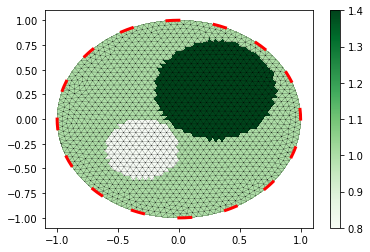

In [55]:
sigma_plt(pts,t,ix_ele, obj.sigma)


In [31]:
def assemble_A(p, t, edges, el_L, el_len, z, sigma):
    
    B1 = assemble_B1(p, t, sigma)
    B2 = assemble_B2(el_L, z, p, edges)
    C = assemble_C(el_L, z, p, edges)
    D = assemble_D(el_L,z, el_len)
    
    N = len(p)
    
    A = np.zeros((N+el_L-1,N+el_L-1))
    
    A[0:N,0:N] = B1+B2
    A[0:N,N: ] = C
    A[N:, 0:N] = C.T
    A[N:, N:] = D
    
    return A
    

In [32]:
def adj_current(A, el_L):
    # D: Compute matrix of adjacent current patterns for a given amplitude (A) in mA and number of electrodes (el_L)
    I = np.zeros((el_L, el_L-1))
    
    for k in range(el_L-1):
        I[k,k]=1
        I[k+1,k]=-1
        
    return A*I


In [33]:
def trig_current(A, el_L):
    
    I = np.zeros((el_L-1, el_L))
    
    dt = (2*pi/el_L)*np.linspace(0, el_L-1, el_L)
    
    
    for k in range(el_L-1):
        
        if k+1<=el_L/2:
            I[k, :] = A*np.cos((k+1)*dt)
        else:
            I[k, :] = A*np.sin((k+1-el_L/2)*dt)
    
    return I
                
                

In [34]:
def left(current, N, el_L):
    # D: y is the left-hand side of the equation Ax=f, it is computed for a given current pattern applied at the boundary
    
    y=np.zeros(N+el_L-1)
    
    for k in range(el_L-1):
        
        y[k+N]=current[0]-current[k+1]
    
    return y

In [35]:
I = trig_current(1.5, el_L)

f = np.zeros((N+el_L-1, el_L-1))

for j in range(el_L-1):
    f[:,j]=left(I[j,:], len(pts), el_L)

I.shape

(15, 16)

In [36]:
def sim_voltages(beta, el_L):
    
    M = np.zeros((el_L,el_L-1))
    M[0,:] = 1
    
    for j in range(el_L-1):
        M[0,j]=1
        M[j+1,j]=-1 
    
    
    return np.matmul(M,beta)
      

def forward(I, pts, el_center, t, edges, el_L, el_len, sigma, z=0.05):
    
    X = assemble_A(pts, t, edges, el_L, el_len, z, sigma)
        
    
    Uh = np.zeros((el_L, el_L-1))
    uh = np.zeros((el_L, el_L-1))
    
    for j in range(el_L-1):
        y = left(I[j,:], len(pts), el_L)
       
        sol, info = cg(X, y)
        
        if info==0:
            beta = sol[len(pts):]
            beta = np.array(beta)

            uh[:,j] = sol[el_center] 

            Uh[:,j] = sim_voltages(beta, el_L)
        else: 
            print('Convergence not achieved')
        
        
    return Uh, uh
    
    

In [56]:
Uh, uh = forward(I, pts, el_center, t, edges, el_L, el_len, obj.sigma, z=0.01)

In [57]:
print_matrix(Uh.T)

4.010511939481864 3.5772155834213173 2.7522901127000656 1.632896188573153 0.1674092005396433 -1.4228690622607356 -2.838485834168637 -3.813545600620926 -4.196179118439613 -3.9280707039541256 -3.00057236159069 -1.5675494159369654 0.08284001277239042 1.6964879416819096 3.0150907205378545 3.8325303972634934 
2.215555022293967 1.4964245064882706 0.0014114203373188938 -1.5145728597571806 -2.236283247739196 -1.5755228474974587 0.10857331719169284 1.8074526891578813 2.504129510491633 1.7749251591865576 0.003863808888554273 -1.7619297351758059 -2.4887733962501093 -1.7983114789780636 -0.10700198802961497 1.570060119391554 
1.7112249885589519 0.6274801810769066 -1.1287191614581205 -1.5228706845852278 0.04211703530142457 1.6680264958971585 1.2673989436389579 -0.7103800440819862 -1.8260446689740477 -0.7042899441062096 1.2860084210935925 1.6763017758013594 -0.0038725202966413135 -1.6930945067431977 -1.319619373300412 0.630333062177492 
1.4755633598531865 0.019303814013192085 -1.3474528403901238 0.02

In [39]:
def print_matrix(matrix):
    
    (m, n) = matrix.shape
    
    for i in range(m):
        for j in range(n):
            print(str(matrix[i, j]) + ' ', end='')
        print()

In [ ]:
print_matrix(I)

In [42]:
anomaly_2 = []
obj_2 = conductivity(t, anomaly_2, 1)

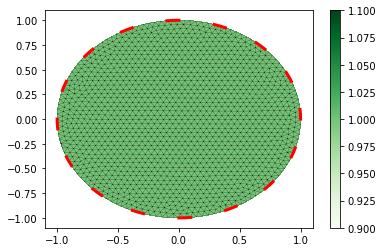

In [43]:
obj_2.sigma

sigma_plt(pts,t,ix_ele, obj_2.sigma)

In [44]:
U2, uh2 = forward(I,pts, el_center, t, edges, el_L, el_len, obj_2.sigma, z=0.01)

In [46]:
print_matrix(U2.T)

4.320069772272945 3.9894710413932155 3.051567746259759 1.6516595238562268 -0.0001306524286855592 -1.6537598911295814 -3.064138616287585 -3.9980205945222593 -4.318136025355247 -3.9898849348606404 -3.0538613114361253 -1.6515946076855894 0.00039199103539734343 1.6599756525524654 3.0604765632134363 3.9959143431222683 
2.4259397123016706 1.7138681326588654 -0.0006865060506272904 -1.7148952368988497 -2.425367219095675 -1.7154696989782277 0.0021562844807320567 1.718229089710835 2.4240451633717526 1.7143693571160823 -0.0009799014650804594 -1.7148412856321837 -2.4218138732883667 -1.7180243793497085 -0.0035048367666844116 1.7169751978854653 
1.8059391431937142 0.6903202157584869 -1.2735924504510325 -1.6655191533747657 -0.0003302972144013757 1.6673011697307418 1.2810090105677177 -0.6901200058641777 -1.8030360646633867 -0.6898631403543504 1.2769859764442417 1.6661477260844393 0.0009786244342140872 -1.6736485853726508 -1.2838138427034393 0.6912416737846487 
1.5091544866511706 0.0018147125275255831 

In [ ]:
np.sum(U2.T[0,:])